Import modules


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from pprint import pprint
import utils as u

Loading training and testing data

In [2]:
plt.ion()

# Load the LB and HB LSFs and convert them from Q15 format to their real value representation within (0, PI/2)
X = u.q15_to_lsf(np.load('./data/train/line_spectrum_frequency_low_band_speech.npy'))
y = u.q15_to_lsf(np.load('./data/train/line_spectrum_frequency_high_band_speech.npy'))

X_test = u.q15_to_lsf(np.load('./data/test/line_spectrum_frequency_low_band_speech.npy'))
y_test = u.q15_to_lsf(np.load('./data/test/line_spectrum_frequency_high_band_speech.npy'))

# appending delta features|
X = np.hstack((X, u.deltas(X)))
X_test = np.hstack((X_test, u.deltas(X_test)))


# convert data to series of data with time span of 5
X_train, X_valid, y_train, y_valid = u.train_valid_split(X, y, step_left=2, step_right=2, valid_size=0.1, shuffle=True, random_state=0)
X_test = u.serialized(X_test, step_left=2, step_right=2)

# Calculate data size for training, validation and testing
num_train_data = X_train.shape[0]
num_valid_data = X_valid.shape[0]
num_test_data = X_test.shape[0]

# truncate training data size to 1%, 10%, 100% for training evaluation
samples_1 = num_train_data // 100
samples_10 = num_train_data // 10
samples_100 = num_train_data
results = {}

dim_x = X_train.shape[-1]
dim_y = y_train.shape[-1]

print("Input Dimension: %d" % (dim_x))
print("Output Dimension: %d" % (dim_y))

print("Total Training data %d, \tequivalent to %s in time" % (num_train_data, u.frame_to_hms(num_train_data)))
print("Total Validating data %d, \tequivalent to %s in time" % (num_valid_data, u.frame_to_hms(num_valid_data)))
print("Total Testing data %d, \tequivalent to %s in time" % (num_test_data, u.frame_to_hms(num_test_data)))

Input Dimension: 20
Output Dimension: 6
Total Training data 400953, 	equivalent to 2:13:39.060 in time
Total Validating data 44550, 	equivalent to 0:14:51.000 in time
Total Testing data 1386, 	equivalent to 0:00:27.720 in time


(0, 1.5707963267948966)

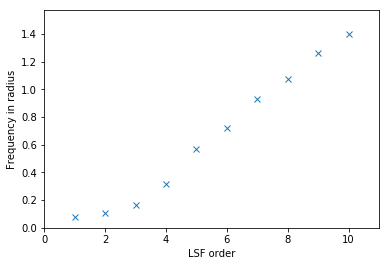

In [3]:
# visualized one set of 10th order LB LSF values
LSF_example = X_train[0, 2, :10]
plt.plot(np.arange(1,11,1), LSF_example, 'x')
plt.xlabel('LSF order')
plt.ylabel('Frequency in radius')
plt.xlim((0,11))
plt.ylim((0, np.pi/2))

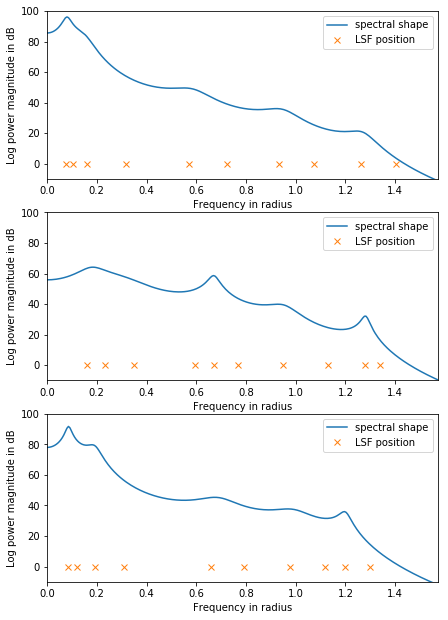

In [4]:
# Plot several 10th-order LB LSFs from training set together with their spectral representation
u.plot_lsf(X_train[0:3, 2, :10])

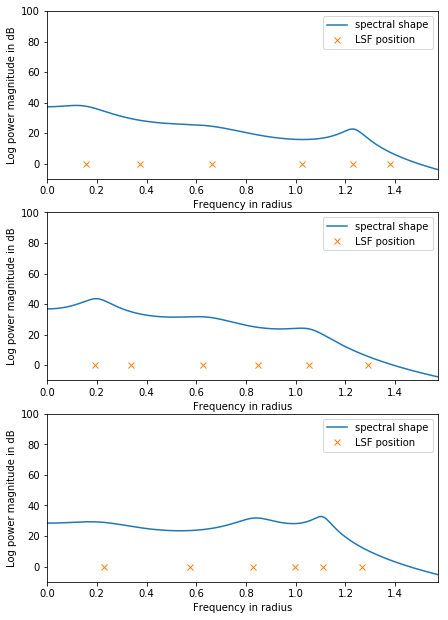

In [5]:
# Plot several 6th-order HB LSFs from training set together with their spectral representation
u.plot_lsf(y_train[0:3, :])

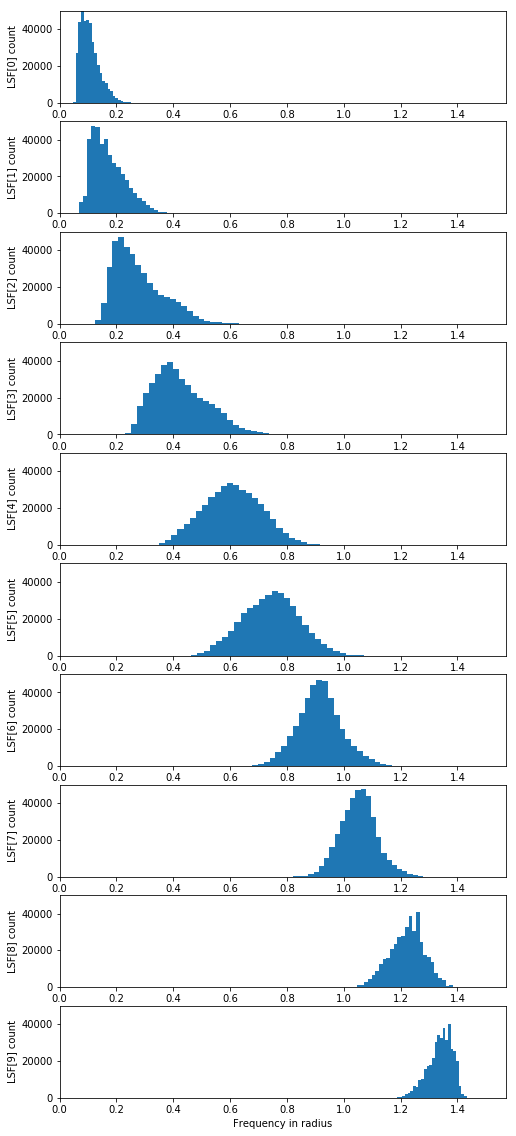

In [6]:
# Plot the histogram for each of the LB LSF dimension
u.plot_lsf_hist(X_train[:, 2, :10])

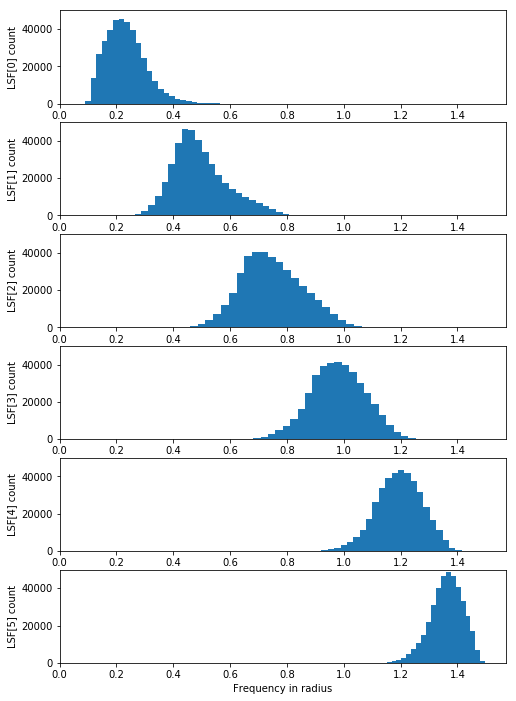

In [7]:
# Plot the histogram for each of the HB LSF dimension
u.plot_lsf_hist(y_train)

In [8]:
# Build benchmark VQ codebook model
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from scipy.cluster.vq import vq

def vq_evaluate(X, y, codebook):
    dim_x = X.shape[-1]
    dim_y = y.shape[-1]
    
    num_data = X.shape[0]
    c_id, _ = vq(X, codebook[:, :dim_x])
    
    yp = np.zeros_like(y)
    for i in range(num_data):
        yp[i, :] = codebook[c_id[i], -dim_y:]

    return mean_squared_error(y, yp)

model = MiniBatchKMeans(n_clusters=256, random_state=0)

results['VQ_Codebook'] = {}
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    
    # combine LB and HB LSFs for K-Means clustering
    start = time()
    model.fit(np.hstack((X_train[:samples, 2, :], y_train[:samples, :])))
    end = time()
    
    codebook = np.array(model.cluster_centers_)
    error_train = vq_evaluate(X_train[:10000, 2, :], y_train[:10000, :], codebook)
    error_valid = vq_evaluate(X_valid[:, 2, :], y_valid, codebook)
    error_test = vq_evaluate(X_test[:, 2, :], y_test, codebook)

    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("VQ Codebook trained on %d samples, taking %.2f seconds" % (samples, end-start))

    results['VQ_Codebook'][i] = result
    
pprint(results['VQ_Codebook'])

VQ Codebook trained on 4009 samples, taking 0.32 seconds
VQ Codebook trained on 40095 samples, taking 3.45 seconds
VQ Codebook trained on 400953 samples, taking 28.69 seconds
{0: {'error_test': 0.011445134538188927,
     'error_train': 0.010251017975557771,
     'error_valid': 0.01085070221350943},
 1: {'error_test': 0.010037587381168262,
     'error_train': 0.009132436034607175,
     'error_valid': 0.009192487859091662},
 2: {'error_test': 0.009819540328774043,
     'error_train': 0.008935915096753197,
     'error_valid': 0.008916598911652121}}


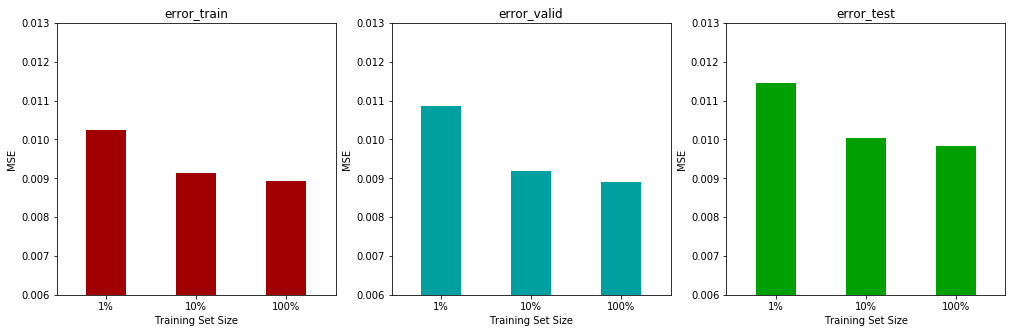

In [15]:
u.plot_model_result(results['VQ_Codebook'], ylim=(0.006, 0.013))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6)                 126       
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________
Linear regression model trained on 4009 samples, taking 139.08 seconds
Linear regression model trained on 40095 samples, taking 53.70 seconds
Linear regression model trained on 400953 samples, taking 91.06 seconds
{0: {'error_test': 0.008637292595502274,
     'error_train': 0.006965933018922806,
     'error_valid': 0.0070041889446870115},
 1: {'error_test': 0.00828135364606955,
     'error_train': 0.006827662876248359,
     'error_valid': 0.006827325212082478},
 2: {'error_test': 0.008094102586384374,
     'error_train': 0.006777103373408318,
     'error_valid': 0.006775780265145297}}


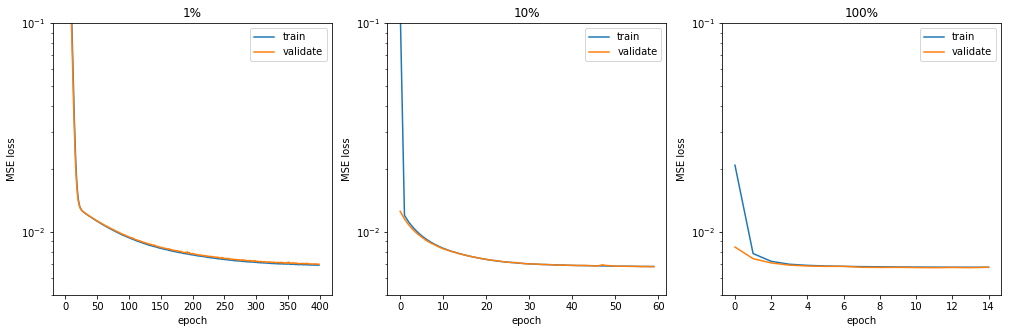

In [16]:
# Build benchmark linear regression model
from models import linear_regression

model = linear_regression(dim_x, dim_y, lr=1e-3)
params = model.get_weights()

results['Linear_Regression'] = {}
plt.figure(figsize=(17,5))
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    
    if samples == samples_1:
        n_epoch = 400
        verbose = 0
    elif samples == samples_10:
        n_epoch = 60
        verbose = 0
    else:
        n_epoch = 15
        verbose = 0
    
    start = time()
    model.set_weights(params)
    history = model.fit(X_train[:samples, 2, :], y_train[:samples, :], epochs=n_epoch, batch_size=128, verbose=verbose, validation_data=(X_valid[:, 2, :], y_valid), shuffle=True)
    end = time()
    
    error_train = model.evaluate(X_train[:10000, 2, :], y_train[:10000, :], batch_size=128, verbose=verbose)
    error_valid = model.evaluate(X_valid[:, 2, :], y_valid, batch_size=128, verbose=verbose)
    error_test = model.evaluate(X_test[:, 2, :], y_test, batch_size=128, verbose=verbose)
    
    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("Linear regression model trained on %d samples, taking %.2f seconds" % (samples, end-start))
    
    titles = ["1%", "10%", "100%"]
    plt.subplot(1, 3, i+1)
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('MSE loss')
    plt.ylim((0.005, 0.1))
    plt.title(titles[i])
    plt.legend(['train', 'validate'], loc='upper right')
    
    results['Linear_Regression'][i] = result
    
pprint(results['Linear_Regression'])

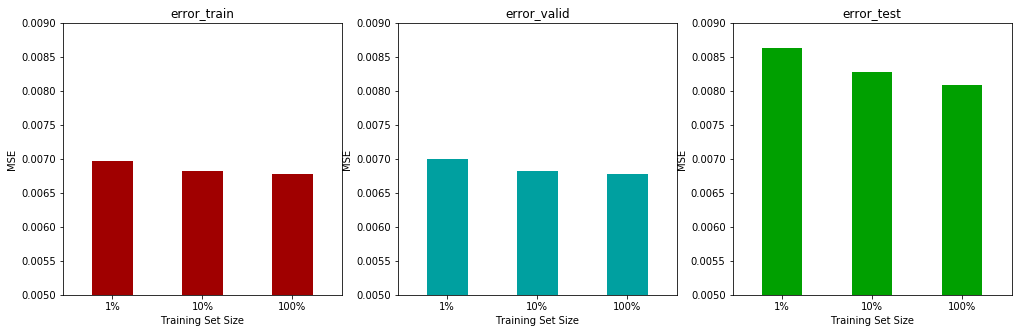

In [19]:
u.plot_model_result(results['Linear_Regression'], ylim=(0.005, 0.009))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               2688      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 774       
Total params: 3,462
Trainable params: 3,462
Non-trainable params: 0
_________________________________________________________________
MLP model trained on 4009 samples, taking 158.11 seconds
MLP model trained on 40095 samples, taking 84.41 seconds
MLP model trained on 400953 samples, taking 134.25 seconds
{0: {'error_test': 0.007168493350540405,
     'error_train': 0.006046388159692288,
     'error_valid': 0.006172936077069755},
 1: {'error_test': 0.00719322840525926,
     'error_train': 0.006025039656460285,
     'error_valid': 0.006063014085056505},
 2: {'error_test': 0.0069328592041934724,
     'error_train': 0.005881064710021019,
     'error_valid': 0.005891

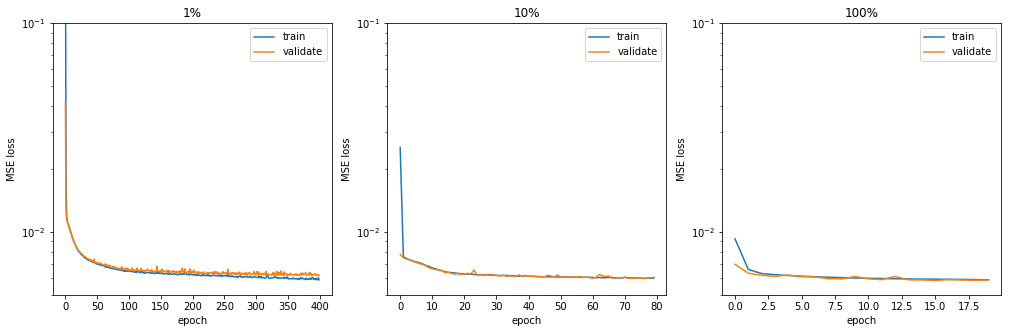

In [24]:
# Build 1 hidden layer MLP model
from models import mlp

model = mlp(dim_x, dim_y, nl=1, nn=128, dropout=False, lr=1e-3)
params = model.get_weights()

results['MLP'] = {}
plt.figure(figsize=(17,5))
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    
    if samples == samples_1:
        n_epoch = 400
        verbose = 0
    elif samples == samples_10:
        n_epoch = 80
        verbose = 0
    else:
        n_epoch = 20
        verbose = 0
    
    start = time()
    model.set_weights(params)
    history = model.fit(X_train[:samples, 2, :], y_train[:samples, :], epochs=n_epoch, batch_size=128, verbose=verbose, validation_data=(X_valid[:, 2, :], y_valid), shuffle=True)
    end = time()
    
    error_train = model.evaluate(X_train[:10000, 2, :], y_train[:10000, :], batch_size=128, verbose=verbose)
    error_valid = model.evaluate(X_valid[:, 2, :], y_valid, batch_size=128, verbose=verbose)
    error_test = model.evaluate(X_test[:, 2, :], y_test, batch_size=128, verbose=verbose)
    
    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("MLP model trained on %d samples, taking %.2f seconds" % (samples, end-start))
    
    titles = ["1%", "10%", "100%"]
    plt.subplot(1, 3, i+1)
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('MSE loss')
    plt.ylim((0.005, 0.1))
    plt.title(titles[i])
    plt.legend(['train', 'validate'], loc='upper right')
    
    results['MLP'][i] = result
    
pprint(results['MLP'])

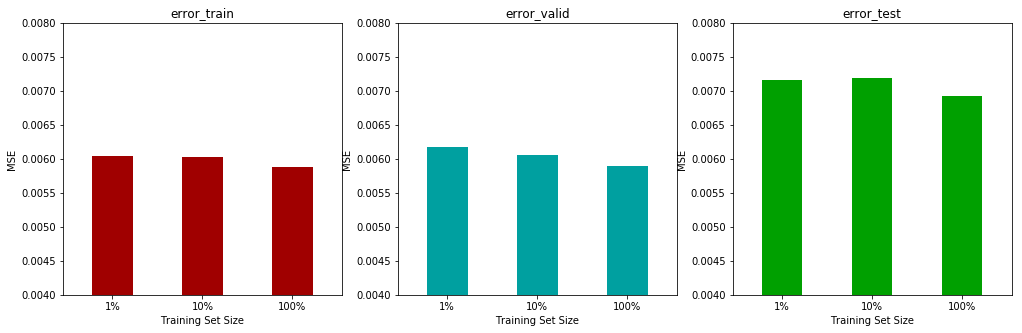

In [26]:
u.plot_model_result(results['MLP'], ylim=(0.004, 0.008))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_37 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 1542      
Total params: 138,502
Trainable params: 138,502
Non-trainable params: 0
_________________________________________________________________
MLP 

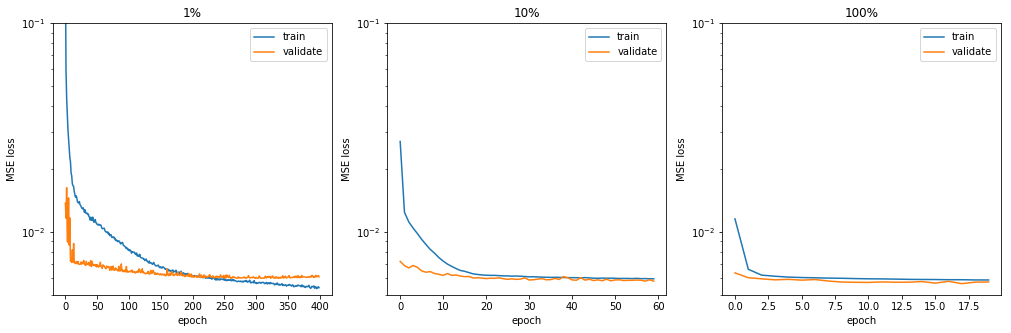

In [33]:
# Improve on the basic MLP model
from models import mlp

model = mlp(dim_x, dim_y, nl=3, nn=256, dropout=True)
params = model.get_weights()

results['MLP2'] = {}
plt.figure(figsize=(17,5)) 
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    
    if samples == samples_1:
        n_epoch = 400
        verbose = 0
    elif samples == samples_10:
        n_epoch = 60
        verbose = 0
    else:
        n_epoch = 20
        verbose = 0
    
    start = time()
    model.set_weights(params)
    history = model.fit(X_train[:samples, 2, :], y_train[:samples, :], epochs=n_epoch, batch_size=128, verbose=verbose, validation_data=(X_valid[:, 2, :], y_valid), shuffle=True)
    end = time()
    
    error_train = model.evaluate(X_train[:10000, 2, :], y_train[:10000, :], batch_size=128, verbose=verbose)
    error_valid = model.evaluate(X_valid[:, 2, :], y_valid, batch_size=128, verbose=verbose)
    error_test = model.evaluate(X_test[:, 2, :], y_test, batch_size=128, verbose=verbose)
    
    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("MLP model trained on %d samples, taking %.2f seconds" % (samples, end-start))

    titles = ["1%", "10%", "100%"]
    plt.subplot(1, 3, i+1)
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('MSE loss')
    plt.ylim((0.005, 0.1))
    plt.title(titles[i])
    plt.legend(['train', 'validate'], loc='upper right')
    
    results['MLP2'][i] = result
    
pprint(results['MLP2'])

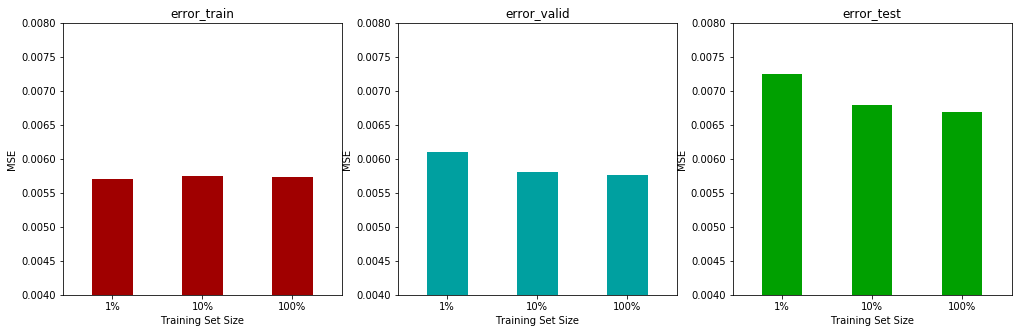

In [37]:
u.plot_model_result(results['MLP2'], ylim=(0.004, 0.008))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                21760     
_________________________________________________________________
dense_43 (Dense)             (None, 6)                 390       
Total params: 22,150
Trainable params: 22,150
Non-trainable params: 0
_________________________________________________________________
LSTM model trained on 4009 samples, taking 142.34 seconds
LSTM model trained on 40095 samples, taking 310.69 seconds
LSTM model trained on 400953 samples, taking 922.64 seconds
{0: {'error_test': 0.0070371187156305515,
     'error_train': 0.005981074649095535,
     'error_valid': 0.006168535490207767},
 1: {'error_test': 0.006898266410463171,
     'error_train': 0.005593987742066383,
     'error_valid': 0.0058098623992960926},
 2: {'error_test': 0.006721743619039891,
     'error_train': 0.005438408514857292,
     'error_valid': 

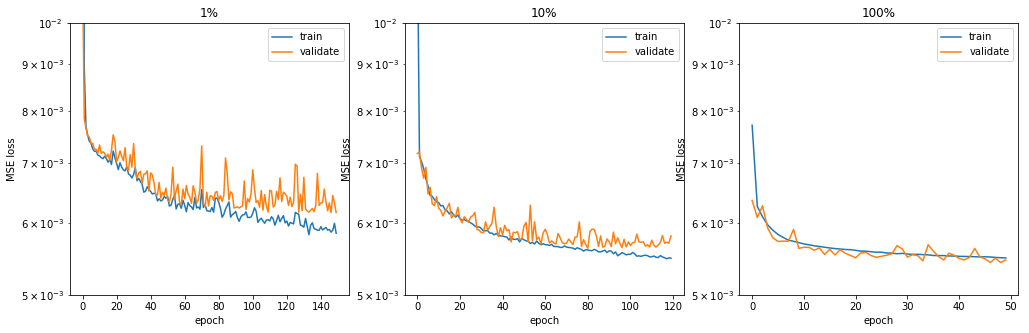

In [42]:
# Build basic LSTM model
from models import lstm

time_step = 2

model = lstm(dim_x, dim_y, time_step, nl=1, nn=64, lr=1e-2)
params = model.get_weights()

results['LSTM'] = {}
plt.figure(figsize=(17,5))
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    
    if samples == samples_1:
        n_epoch = 150
        verbose = 0
    elif samples == samples_10:
        n_epoch = 120
        verbose = 0
    else:
        n_epoch = 50
        verbose = 0
    
    start = time()
    model.set_weights(params)
    history = model.fit(X_train[:samples, 1:3, :], y_train[:samples, :], epochs=n_epoch, batch_size=128, verbose=verbose, validation_data=(X_valid[:, 1:3, :], y_valid), shuffle=True)
    end = time()
    
    error_train = model.evaluate(X_train[:10000, 1:3, :], y_train[:10000, :], batch_size=128, verbose=verbose)
    error_valid = model.evaluate(X_valid[:, 1:3, :], y_valid, batch_size=128, verbose=verbose)
    error_test = model.evaluate(X_test[:, 1:3, :], y_test, batch_size=128, verbose=verbose)
    
    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("LSTM model trained on %d samples, taking %.2f seconds" % (samples, end-start))

    titles = ["1%", "10%", "100%"]
    plt.subplot(1, 3, i+1)
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('MSE loss')
    plt.ylim((0.005, 0.01))
    plt.title(titles[i])
    plt.legend(['train', 'validate'], loc='upper right')
    
    results['LSTM'][i] = result
    
pprint(results['LSTM'])

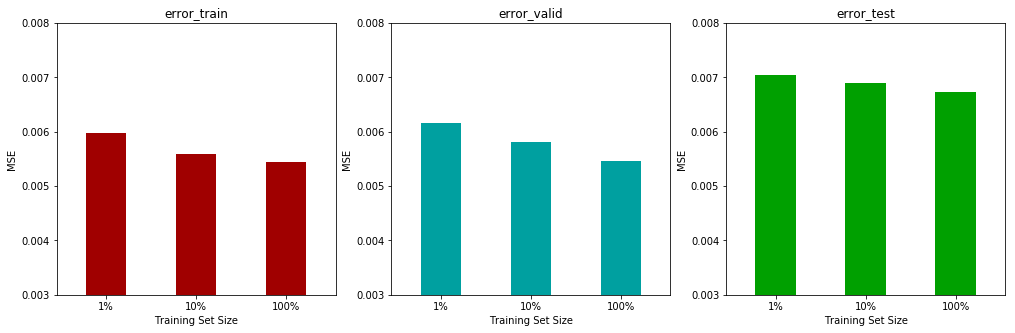

In [45]:
u.plot_model_result(results['LSTM'], ylim=(0.003, 0.008))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 5, 64)             21760     
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_49 (Dense)             (None, 6)                 390       
Total params: 55,174
Trainable params: 55,174
Non-trainable params: 0
_________________________________________________________________
LSTM model trained on 4009 samples, taking 340.99 seconds
LSTM model trained on 40095 samples, taking 768.65 seconds
LSTM model trained on 400953 samples, taking 1989.72 seconds
{0: {'error_test': 0.01001622188771829,
     'error_train': 0.006153949077427387,
     'error_valid': 0.008624525393968747},
 1: {'error_test': 0.0071917359957748336,
     'error_train': 0.004448629254102707,
     'error_val

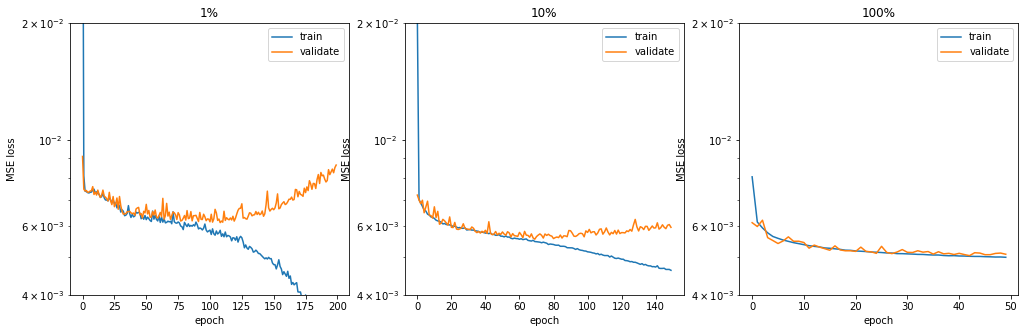

In [51]:
# Improve on basic LSTM model
from models import lstm

time_step = 5

model = lstm(dim_x, dim_y, time_step, nl=2, nn=64, lr=1e-2)
params = model.get_weights()

results['LSTM2'] = {}
plt.figure(figsize=(17,5))
for i, samples in enumerate([samples_1, samples_10, samples_100]):
    result = {}
    
    if samples == samples_1:
        n_epoch = 200
        verbose = 0
    elif samples == samples_10:
        n_epoch = 150
        verbose = 0
    else:
        n_epoch = 50
        verbose = 0
    
    start = time()
    model.set_weights(params)
    history = model.fit(X_train[:samples, 0:5, :], y_train[:samples, :], epochs=n_epoch, batch_size=128, verbose=verbose, validation_data=(X_valid[:, 0:5, :], y_valid), shuffle=True)
    end = time()
    
    error_train = model.evaluate(X_train[:10000, 0:5, :], y_train[:10000, :], batch_size=128, verbose=verbose)
    error_valid = model.evaluate(X_valid[:, 0:5, :], y_valid, batch_size=128, verbose=verbose)
    error_test = model.evaluate(X_test[:, 0:5, :], y_test, batch_size=128, verbose=verbose)
    
    result['error_train'] = error_train
    result['error_valid'] = error_valid
    result['error_test'] = error_test
    
    # Success
    print("LSTM model trained on %d samples, taking %.2f seconds" % (samples, end-start))

    titles = ["1%", "10%", "100%"]
    plt.subplot(1, 3, i+1)
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('MSE loss')
    plt.ylim((0.004, 0.02))
    plt.title(titles[i])
    plt.legend(['train', 'validate'], loc='upper right')
    
    results['LSTM2'][i] = result
    
pprint(results['LSTM2'])

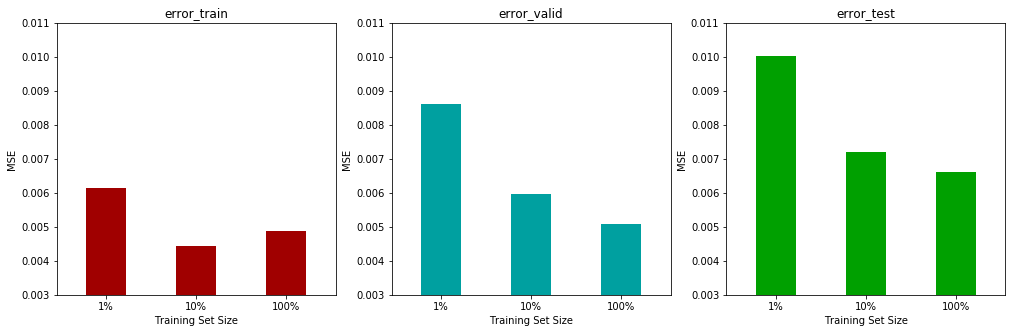

In [52]:
u.plot_model_result(results['LSTM2'], ylim=(0.003, 0.011))

In [56]:
# Model Robustness Validation using K-fold cross validation
from sklearn.model_selection import KFold

X = u.serialized(X, step_left=2, step_right=2)


kf = KFold(n_splits=10, shuffle=True, random_state=0)

time_step = 5

model = lstm(dim_x, dim_y, time_step, nl=2, nn=64, lr=1e-2)
params = model.get_weights()

print(X.shape)
print(X_test.shape)

verbose = 0
count = 0
for train_index, valid_index in kf.split(X):
    count += 1
    
    X_train = X[train_index, :, :]
    y_train = y[train_index, :]

    X_valid = X[valid_index, :, :]
    y_valid = y[valid_index, :]

    # reset model parameters for each cross validation
    model.set_weights(params)
    model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=verbose, validation_data=(X_valid, y_valid), shuffle=True)
    mse_valid = model.evaluate(X_valid, y_valid, verbose=verbose)
    mse_test = model.evaluate(X_test, y_test, verbose=verbose)
    print("Fold %d, Validation Error: %.5f, Testing MSE: %.5f" % (count, mse_valid, mse_test))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 5, 64)             21760     
_________________________________________________________________
lstm_25 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_53 (Dense)             (None, 6)                 390       
Total params: 55,174
Trainable params: 55,174
Non-trainable params: 0
_________________________________________________________________
(445503, 5, 20)
(1386, 5, 20)
Fold 1, Validation Error: 0.00509, Testing MSE: 0.00678
Fold 2, Validation Error: 0.00511, Testing MSE: 0.00722
Fold 3, Validation Error: 0.00523, Testing MSE: 0.00702
Fold 4, Validation Error: 0.00515, Testing MSE: 0.00681
Fold 5, Validation Error: 0.00525, Testing MSE: 0.00686
Fold 6, Validation Error: 0.00516, Testing MSE: 0.00633
Fold 7, Validation Error: 0.00524, T